# Load packages

In [1]:
import os
os.getcwd(),os.listdir()

# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt

from zipfile import ZipFile

# EDA

In [2]:
#data loading
file_path1 = '../data/ibtracs.since1980.list.v04r01.csv.zip'  
zip_file = ZipFile(file_path1)
# zip_file.open('file3.txt')
# df1 = pd.read_csv(file_path1)
df1 = pd.read_csv(zip_file.open('ibtracs.since1980.list.v04r01.csv'))

df1 = df1.iloc[:, 1:]

df1


/var/folders/y9/hy0mnzl536ng5c4qz99ppmf00000gn/T/ipykernel_98192/1258777372.py:6: DtypeWarning: Columns (1,2,8,9,14,19,20,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(zip_file.open('ibtracs.since1980.list.v04r01.csv'))


,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,Year,,,,,,,degrees_north,degrees_east,kts,...,second,kts,second,ft,nmile,nmile,nmile,nmile,kts,degrees
1,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,,...,,,,,,,,,6,350
2,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,,...,,,,,,,,,6,350
3,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,,...,,,,,,,,,5,360
4,1980,1,SP,MM,PENI,1980-01-01 09:00:00,TS,-11.7,172.4,,...,,,,,,,,,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297547,2024,81,WP,MM,YINXING,2024-11-04 12:00:00,NR,14.3,130.1,,...,,,,,,,,,15,310
297548,2024,81,WP,MM,YINXING,2024-11-04 15:00:00,NR,14.7,129.6,,...,,,,,,,,,13,305
297549,2024,81,WP,MM,YINXING,2024-11-04 18:00:00,NR,15.1,129.0,,...,,,,,,,,,15,305
297550,2024,81,WP,MM,YINXING,2024-11-04 21:00:00,NR,15.6,128.3,,...,,,,,,,,,18,305


In [3]:
#keep what we will use for learning(and the output R)

df2 = df1[['LAT','LON', 'USA_WIND','USA_R34_NE', 'USA_R50_NE', 'USA_R64_NE','USA_RMW']].copy() # ,'WMO_PRES'
# df2['land'] = df2['land'].apply(lambda x: 1 if str(x).strip().lower() == 'true' else 0)

df2 = df2.iloc[1:]  # Remove the first row

df2.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Reset index after dropping rows
df2.reset_index(drop=True, inplace=True)

df2


,LAT,LON,USA_WIND,USA_R34_NE,USA_R50_NE,USA_R64_NE,USA_RMW
0,-12.5,172.5,25,NaN,NaN,NaN,NaN
1,-12.2,172.4,25,NaN,NaN,NaN,NaN
2,-11.9,172.4,25,NaN,NaN,NaN,NaN
3,-11.7,172.4,25,NaN,NaN,NaN,NaN
4,-11.5,172.5,25,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
297546,14.3,130.1,64,91,NaN,NaN,22
297547,14.7,129.6,67,91,NaN,NaN,20
297548,15.1,129.0,70,91,NaN,NaN,17
297549,15.6,128.3,72,89,NaN,NaN,15


In [4]:
# df.loc[df['Age'] < 25, 'Status'] = 'Complicated'
df2[['USA_R34_NE']] = df2[['USA_R34_NE']].apply(pd.to_numeric, errors='coerce')
df2[['USA_RMW', 'USA_R64_NE','USA_R50_NE']] = df2[['USA_RMW', 'USA_R64_NE','USA_R50_NE']].apply(pd.to_numeric, errors='coerce')
df2[['USA_WIND']] = df2[['USA_WIND']].apply(pd.to_numeric, errors='coerce')
df2[['LAT']] = df2[['LAT']].apply(pd.to_numeric, errors='coerce')
df2 = df2.dropna(subset=['USA_WIND'])
df2.loc[df2['USA_WIND']<64,'USA_R64_NE']=0
df2.loc[df2['USA_WIND']<50,'USA_R50_NE']=0
df2.loc[df2['USA_WIND']<34,'USA_R34_NE']=0
df3=df2.copy()
numeric_columns = ['LAT', 'USA_R34_NE', 'USA_RMW', 'USA_WIND']
df3.dropna(subset=numeric_columns, inplace=True)
df3

,LAT,LON,USA_WIND,USA_R34_NE,USA_R50_NE,USA_R64_NE,USA_RMW
151179,27.3,129.2,50.0,30.0,NaN,0.0,60.0
151254,23.4,68.8,55.0,25.0,NaN,0.0,30.0
151265,13.5,-100.2,40.0,120.0,0.0,0.0,40.0
151266,13.4,-100.1,45.0,120.0,0.0,0.0,40.0
151267,13.3,-100.0,50.0,120.0,NaN,0.0,40.0
...,...,...,...,...,...,...,...
297546,14.3,130.1,64.0,91.0,NaN,NaN,22.0
297547,14.7,129.6,67.0,91.0,NaN,NaN,20.0
297548,15.1,129.0,70.0,91.0,NaN,NaN,17.0
297549,15.6,128.3,72.0,89.0,NaN,NaN,15.0


In [5]:
df_cleaned=df3.copy()
df_cleaned.dropna(subset=['LAT', 'USA_R34_NE', 'USA_RMW', 'USA_WIND','USA_R64_NE','USA_R50_NE'], inplace=True)
df_cleaned

,LAT,LON,USA_WIND,USA_R34_NE,USA_R50_NE,USA_R64_NE,USA_RMW
151265,13.5,-100.2,40.0,120.0,0.0,0.0,40.0
151266,13.4,-100.1,45.0,120.0,0.0,0.0,40.0
151307,16.2,-112.0,45.0,50.0,0.0,0.0,20.0
151308,16.2,-112.1,40.0,40.0,0.0,0.0,35.0
151309,16.3,-112.3,35.0,30.0,0.0,0.0,50.0
...,...,...,...,...,...,...,...
297533,15.1,-76.4,40.0,70.0,0.0,0.0,70.0
297534,15.4,-76.6,40.0,80.0,0.0,0.0,55.0
297535,15.8,-76.9,40.0,90.0,0.0,0.0,40.0
297536,9.7,138.2,29.0,0.0,0.0,0.0,65.0


In [6]:
df4=df_cleaned.copy()
# Define constants
omega = 7.292 * (2 ** -5)
df4 = df4.loc[(df2['LAT'] >= 24)&(df4['LAT'] <= 31)&(df4['LON'] >= -84)&(df4['LON'] <= -79)]
# Calculate f = omega * sin(latitude) (latitude is in degrees, so convert to radians)
df4['f'] = omega * np.sin(np.radians(df4['LAT']))

# Calculate M_17.5
df4['M_17.5'] = df4['USA_R34_NE'] * 17.5 + 0.5 * df4['USA_R34_NE']**2 * df4['f']

# Calculate M_max (updated calculation as per your formula)
df4['M_max'] = df4['USA_RMW'] * 0.5 * df4['USA_WIND'] + 0.5 * df4['USA_RMW']**2 * df4['f']
df4['M_50'] = df4['USA_R50_NE'] * 0.5 * 50 + 0.5 * df4['USA_R50_NE']**2 * df4['f']
df4['M_64'] = df4['USA_R64_NE'] * 0.5 * 64 + 0.5 * df4['USA_R64_NE']**2 * df4['f']

# Calculate the ratio of M_17.5 to M_max
df4['Ratio_M17.5_to_Mmax'] = df4['M_17.5'] / df4['M_max']
df4['Ratio_M17.5_to_M50'] = df4['M_17.5'] / df4['M_50']
df4['Ratio_M17.5_to_M64'] = df4['M_17.5'] / df4['M_64']

M_max_approx = df4['Ratio_M17.5_to_Mmax'].mean()
M_max_approx

df4.shape



(490, 15)

# Functions for predictions

In [7]:
# Functions
def prepare_data(df,features,target,test_size=.2, random_state=42):
  df.dropna(subset=features + [target], inplace=True)
  X = df[features]
  y = df[target]
  X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, X.index, test_size=test_size, random_state=random_state)
  return X_train, X_test, y_train, y_test, train_idx, test_idx

def train_M_model(X_train,y_train, features, target,model=RandomForestRegressor,random_state=42,n_estimators=100):
  # Train a RandomForestRegressor
  if model==RandomForestRegressor:
    ml_model = model(random_state=random_state, n_estimators=n_estimators)
  else:
    ... # to be filled in
  ml_model.fit(X_train, y_train)
  return ml_model

def predict_M_model(df, features,trained_model):
  return trained_model.predict(df[features])

def update_df(df,features,trained_model,pred_speed='max'):
  df[f'Ratio_M17.5_to_M{pred_speed}_ml'] = predict_M_model(df, features,trained_model)

  if pred_speed=='max':
    df[f'r{pred_speed}_calc']= df['USA_WIND']/df['f']*(np.sqrt(1+2*df['f']*df[f'M_{pred_speed}']/(df['USA_WIND']**2))-1)*2
    M_approx = df[f'Ratio_M17.5_to_M{pred_speed}'].mean()
    df[f'r{pred_speed}_calc_approx']= df['USA_WIND']/df['f']*(np.sqrt(1+(2*df['f']*df['M_17.5']/M_approx/(df['USA_WIND']**2)))-1)*2
    df[f'r{pred_speed}_calc_ml']= df['USA_WIND']/df['f']*(np.sqrt(1+(2*df['f']*df['M_17.5']/df[f'Ratio_M17.5_to_M{pred_speed}_ml']/(df['USA_WIND']**2)))-1)*2

    df[f'r{pred_speed}_calc_rounded'] = df[f'r{pred_speed}_calc'].round()
    df[f'r{pred_speed}_calc_approx_rounded'] = df[f'r{pred_speed}_calc_approx'].round()
    df[f'r{pred_speed}_calc_ml_rounded'] = df[f'r{pred_speed}_calc_ml'].round()
  else:
    speed=int(pred_speed)
    df[f'r{pred_speed}_calc']= speed/df['f']*(np.sqrt(1+2*df['f']*df[f'M_{pred_speed}']/(speed**2))-1)*2
    M_approx = df[f'Ratio_M17.5_to_M{pred_speed}'].mean()
    df[f'r{pred_speed}_calc_approx']= speed/df['f']*(np.sqrt(1+(2*df['f']*df['M_17.5']/M_approx/(speed**2)))-1)*2
    df[f'r{pred_speed}_calc_ml']= speed/df['f']*(np.sqrt(1+(2*df['f']*df['M_17.5']/df[f'Ratio_M17.5_to_M{pred_speed}_ml']/(speed**2)))-1)*2

    df[f'r{pred_speed}_calc_rounded'] = df[f'r{pred_speed}_calc'].round()
    df[f'r{pred_speed}_calc_approx_rounded'] = df[f'r{pred_speed}_calc_approx'].round()
    df[f'r{pred_speed}_calc_ml_rounded'] = df[f'r{pred_speed}_calc_ml'].round()

  return df

def calc_model_error(df,test_indices=None,pred_speed='max'):
  # return model learned model overall error, test error
  if test_indices is not None:
    df_test = df.loc[test_indices].copy()
    return (abs(df[f'r{pred_speed}_calc_ml_rounded']-df['USA_RMW'])/df['USA_RMW']).mean(),(abs(df_test[f'r{pred_speed}_calc_ml_rounded']-df_test['USA_RMW'])/df_test['USA_RMW']).mean()
  else:
    return (abs(df[f'r{pred_speed}_calc_ml_rounded']-df['USA_RMW'])/df['USA_RMW']).mean()

def calc_est_error(df,test_indices=None,pred_speed='max'):
  if test_indices is not None:
    df_test = df.loc[test_indices].copy()
    return (abs(df[f'r{pred_speed}_calc_approx_rounded']-df['USA_RMW'])/df['USA_RMW']).mean(),(abs(df_test[f'r{pred_speed}_calc_approx_rounded']-df_test['USA_RMW'])/df_test['USA_RMW']).mean()
  else:
    return (abs(df[f'r{pred_speed}_calc_approx_rounded']-df['USA_RMW'])/df['USA_RMW']).mean()


# Fitting & Outcomes

In [8]:
# Fitting using the formula 
# Define the features (X) and target (y)
features = ['LAT', 'USA_R34_NE', 'USA_RMW', 'USA_WIND', 'f', 'M_17.5']
target = 'Ratio_M17.5_to_Mmax'
# Prepare data to be trained and tested
X_train, X_test, y_train, y_test, train_idx, test_idx = prepare_data(df4,features,target)
# Train model
rf_Mmax_model=train_M_model(X_train, y_train, features, target)
# Get dataframe with prediciton
df4_udpated=update_df(df4,features,rf_Mmax_model)
#  Calculate the error(s)
print(f'Test error is: {calc_model_error(df4_udpated, test_idx )}')
display((df4_udpated.loc[df4_udpated['USA_R64_NE']>50])[['LAT','LON','USA_WIND','USA_R64_NE','USA_RMW','rmax_calc_ml_rounded']].tail(15))
      

Test error is: (np.float64(0.06996091516336281), np.float64(0.10587826076198169))


,LAT,LON,USA_WIND,USA_R64_NE,USA_RMW,rmax_calc_ml_rounded
173453,27.2,-80.2,105.0,60.0,45.0,34.0
181073,24.5,-83.8,103.0,70.0,30.0,29.0
181074,25.0,-83.1,110.0,75.0,30.0,29.0
181075,25.6,-82.3,107.0,75.0,27.0,27.0
181076,25.9,-81.7,105.0,75.0,25.0,26.0
181077,26.2,-81.0,95.0,75.0,30.0,30.0
181078,27.0,-79.9,100.0,75.0,33.0,31.0
251780,24.0,-81.4,115.0,70.0,10.0,10.0
251781,24.5,-81.5,115.0,70.0,10.0,10.0
251782,24.7,-81.5,115.0,70.0,10.0,10.0


In [9]:
row_index=181078
display(df1.iloc[row_index+1][['SEASON','NAME','LAT','LON','USA_WIND','USA_R34_NE','USA_R50_NE','USA_R64_NE','USA_RMW']])

SEASON         2005
NAME          WILMA
LAT            27.0
LON           -79.9
USA_WIND        100
USA_R34_NE      200
USA_R50_NE      125
USA_R64_NE       75
USA_RMW          33
Name: 181079, dtype: object

(98, 22)


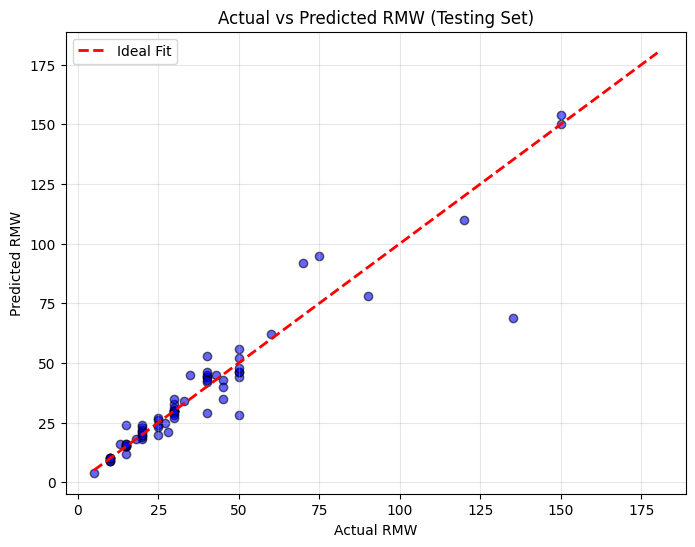

In [10]:
# plottng results 
df4_test = df4_udpated.loc[test_idx].copy()
print(df4_test.shape)
y_test = df4_test['USA_RMW']
y_pred = df4_test['rmax_calc_ml_rounded']
# Scatter plot for actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test,y_pred, color='blue', alpha=0.6, edgecolor='k')
plt.title('Actual vs Predicted RMW (Testing Set)')
plt.xlabel('Actual RMW')
plt.ylabel('Predicted RMW')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [11]:
# Fitting without the M_17.5 feature 
features = [ 'LAT','LON','USA_R34_NE', 'USA_WIND']
target = 'USA_RMW'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, train_idx, test_idx = prepare_data(df4,features,target)
print('Test data shape: ', y_test.shape)
rf_Mmax_model=train_M_model(X_train, y_train, features, target)
print('Test error is: ', (abs(predict_M_model(X_test, features,rf_Mmax_model)-y_test)/y_test).mean())

Test data shape:  (98,)
Test error is:  0.3555793877184467


(98, 22)


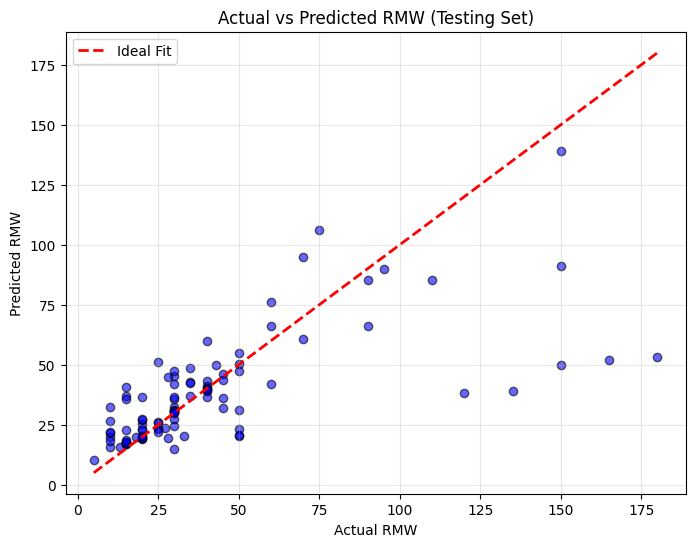

In [12]:
df4_test = df4_udpated.loc[test_idx].copy()
print(df4_test.shape)
y_pred=predict_M_model(X_test, features,rf_Mmax_model)
y_test = df4_test['USA_RMW']
# Scatter plot for actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test,y_pred, color='blue', alpha=0.6, edgecolor='k')
plt.title('Actual vs Predicted RMW (Testing Set)')
plt.xlabel('Actual RMW')
plt.ylabel('Predicted RMW')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Fitting other models 

Below is our experiment with polynomial regression. 
The performance was not as good as random forest. 

In [13]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
features = ['LAT', 'USA_R34_NE', 'USA_RMW', 'USA_WIND', 'f', 'M_17.5']
target = 'Ratio_M17.5_to_Mmax'

def polynomial_regression(df=df4, target_column='Ratio_M17.5_to_Mmax'):
    # Separate features and target variable
    X = df[['LAT', 'USA_R34_NE', 'USA_RMW', 'USA_WIND', 'f', 'M_17.5']]
    y = df[target_column]

    # Split into training (80%), validation (10%), and testing (10%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Create polynomial features
    poly = PolynomialFeatures(degree=4)
    X_train_poly = poly.fit_transform(X_train)
    # X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    # Train the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Evaluate on the validation set
    y_test_pred = model.predict(X_test_poly)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    r2_test = r2_score(y_test, y_test_pred)

    print(f"Results for {target_column}:")
    print(f"Mean Squared Error on Validation Set: {mse_test:.4f}")
    print(f"Mean Absolute Percentage Error on Validation Set: {mape_test:.4f}")
    print(f"R^2 Score on Validation Set: {r2_test:.4f}\n")

    return model, poly

df34_model, df34_poly = polynomial_regression()


Results for Ratio_M17.5_to_Mmax:
Mean Squared Error on Validation Set: 4.3768
Mean Absolute Percentage Error on Validation Set: inf
R^2 Score on Validation Set: 0.3811

